In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import re
import string
import emoji
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
import random
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    
SEED = 42

In [3]:
data = pd.read_csv("IMDB_Dataset.csv")

In [4]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


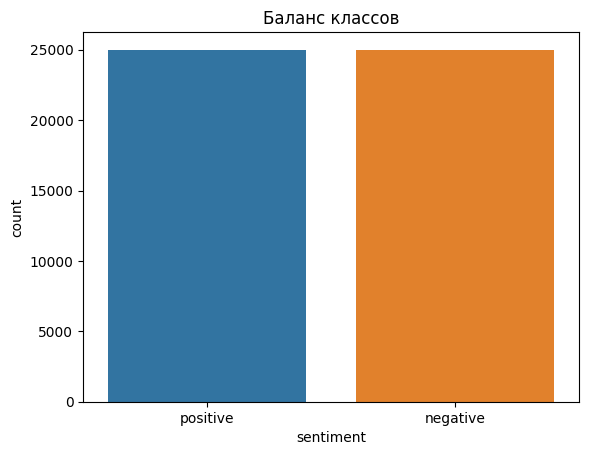

In [7]:
sns.countplot(x=data["sentiment"])
plt.title("Баланс классов")
plt.show()

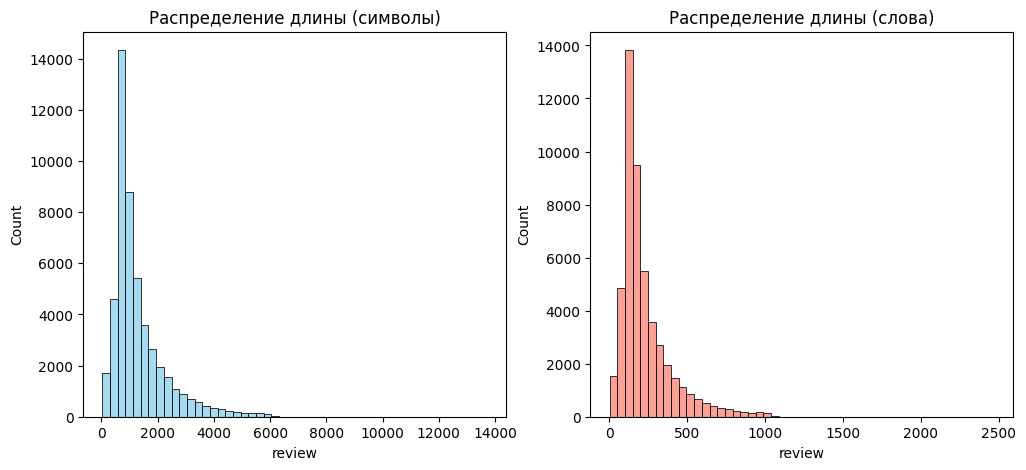

In [8]:
char_len = data["review"].apply(len)
word_len = data["review"].apply(lambda x: len(x.split()))


fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(char_len, bins=50, ax=axes[0], color="skyblue")
axes[0].set_title("Распределение длины (символы)")
sns.histplot(word_len, bins=50, ax=axes[1], color="salmon")
axes[1].set_title("Распределение длины (слова)")
plt.show()

In [9]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # удаляем HTML-тег
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # удаляем URL
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # удаляем эмодзи
    text = emoji.replace_emoji(text, replace="")
    
    # приводим к нижнему регистру
    text = text.lower()
    
    # удаляем спецсимволы, оставляем буквы и пробел
    text = re.sub(r"[^a-z\s']", " ", text)
    
    # разделяем на слова, удаляем стоп-слова и пустые строки, делаем лемматизацию
    words = [lemmatizer.lemmatize(word) for word in text.split() 
             if word not in stop_words and word != ""]
    
    return words

all_words = []
data["review_clean"] = data["review"].apply(clean_text)
for row in data["review_clean"]:
    all_words.extend(row)

word_counts = Counter(all_words)
print("Топ-20 слов:", word_counts.most_common(20))

Топ-20 слов: [('movie', 102286), ('film', 91376), ('one', 54862), ('like', 41108), ('time', 31377), ('good', 29753), ('character', 27548), ('story', 25102), ('even', 24856), ('get', 24564), ('would', 24229), ('make', 24174), ('see', 24021), ('really', 23083), ('well', 21390), ('scene', 21358), ('much', 19310), ('bad', 18383), ('great', 18192), ('people', 17975)]


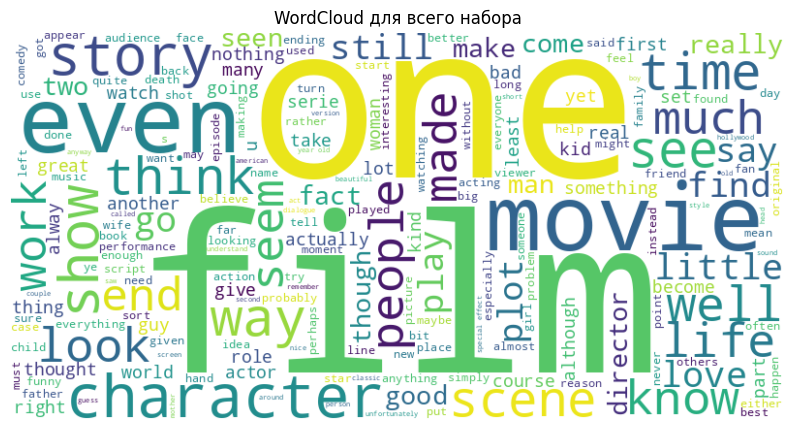

In [10]:
text_all = " ".join([" ".join(words) for words in data["review_clean"]])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_all)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud для всего набора")
plt.show()

In [11]:
print("Пропуски в тексте:", data["review"].isna().sum())
print("Дубликаты:", data.duplicated(subset=["review"]).sum())

Пропуски в тексте: 0
Дубликаты: 418


In [12]:
data = data.drop_duplicates(subset=["review"], keep='first')

data = data.reset_index(drop=True)

print("Дубликаты после удаления:", data.duplicated(subset=["review"]).sum())

Дубликаты после удаления: 0


In [13]:
data

,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,"[basically, there's, family, little, boy, jake..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei's, love, time, money, visually..."
...,...,...,...
49577,I thought this movie did a down right good job...,positive,"[thought, movie, right, good, job, creative, o..."
49578,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49579,I am a Catholic taught in parochial elementary...,negative,"[catholic, taught, parochial, elementary, scho..."
49580,I'm going to have to disagree with the previou...,negative,"[going, disagree, previous, comment, side, mal..."


In [14]:
def extract_features(df, text_col="review_clean"):
    df = df.copy()

    df["word_count"] = df[text_col].apply(len)
    df["unique_word_count"] = df[text_col].apply(lambda x: len(set(x)))
    df["avg_word_length"] = df[text_col].apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
    df["max_word_length"] = df[text_col].apply(lambda x: max([len(w) for w in x]))
    df["punctuation_count"] = df[text_col].apply(lambda x: sum(1 for c in x if c in string.punctuation))

    return df

In [15]:
data = extract_features(data, text_col="review_clean")
data.head()

,review,sentiment,review_clean,word_count,unique_word_count,avg_word_length,max_word_length,punctuation_count
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, mentioned, watching, oz, episo...",164,134,5.615854,13,0
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn...",86,78,6.546512,13,0
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...",84,80,5.761905,12,0
3,Basically there's a family where a little boy ...,negative,"[basically, there's, family, little, boy, jake...",66,52,5.696970,11,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei's, love, time, money, visually...",125,100,5.776000,13,0


In [16]:
y = data["sentiment"]
X = data.drop(["sentiment", "review"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train["review_clean"].astype(str))
X_test_vec  = vectorizer.transform(X_test["review_clean"].astype(str))

In [18]:
X_train_vec.shape

(34707, 5000)

In [19]:
# эксперимент без новых фичей. только работа с тектом
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [20]:
y_pred = nb_model.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print("Accuracy на тесте без фичей:", acc)

Accuracy на тесте без фичей: 0.8539159663865546


In [21]:
numerical = ["word_count", "unique_word_count", 
                         "avg_word_length", "max_word_length", "punctuation_count"]

In [22]:
X_train_features = X_train[numerical].astype(np.float32).values
X_test_features  = X_test[numerical].astype(np.float32).values

In [23]:
# данные 
X_train_final = hstack([X_train_vec, X_train_features])
X_test_final  = hstack([X_test_vec, X_test_features])

In [24]:
X_train_final.shape

(34707, 5005)

In [25]:
nb_model_2 = MultinomialNB()
nb_model_2.fit(X_train_final, y_train)

MultinomialNB()

In [27]:
y_pred = nb_model_2.predict(X_test_final)
acc = accuracy_score(y_test, y_pred)
print("Accuracy на тесте c 5-ю дополнительными фичами:", acc)

Accuracy на тесте c 5-ю дополнительными фичами: 0.8337478991596639


Из двух экспериментов выше можно сделать вывод, что наивный Байес может выдавать лучшее качество без дополнительных фичей

Для повышения качества классификации текстов было проведено дообучение (fine-tuning) предобученной модели RoBERTa-base на наших данных.

Ниже представлен процесс дообучения с пояснения на каждом шаге

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
# разделение данных на тренировочную и тестовую выборки 
set_random_seed(SEED)
label2id = {"negative": 0, "positive": 1}

y = data["sentiment"].map(label2id) 
X = data["review_clean"].apply(lambda tokens: " ".join(tokens))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [40]:
# кастомный PyTorch Dataset для токенизации текстов с заданной максимальной длиной и метками
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [32]:
# загрузка предобученного токенизатора RoBERTa-base
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [42]:
# создание объектов Dataset для обучающей и тестовой выборок
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

In [45]:
# обёртка Dataset в DataLoader для формирования батчей
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
# проверка на правильность сборки DataLoader (первый батч)
batch = next(iter(train_loader))
print(batch["labels"])        
print(batch["labels"].dtype) 

tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0])
torch.int64


In [36]:
# инициализация модели, оптимизатора AdamW и функции потерь CrossEntropyLoss
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

2025-09-16 16:38:14.087297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758040694.253720      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758040694.298367      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# функция для обучения (одна эпоха)
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [38]:
# функция для оценки качества модели на тестовых данных 
def eval_model(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    return acc, f1

In [46]:
# процесс дообучения модели на 3 эпохах
EPOCHS = 3
for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    acc, f1 = eval_model(model, test_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}, F1={f1:.4f}")

Evaluating: 100%|██████████| 930/930 [07:48<00:00,  1.98it/s]


Epoch 1: Loss=0.1156, Accuracy=0.9002, F1=0.9052


Evaluating: 100%|██████████| 930/930 [07:48<00:00,  1.99it/s]


Epoch 2: Loss=0.0811, Accuracy=0.9077, F1=0.9048


Evaluating: 100%|██████████| 930/930 [07:48<00:00,  1.99it/s]

Epoch 3: Loss=0.0652, Accuracy=0.9122, F1=0.9111


In [47]:
# сохраниение модели 
model.save_pretrained("./model_sentiment")
tokenizer.save_pretrained("./model_sentiment")

('./model_sentiment/tokenizer_config.json',
 './model_sentiment/special_tokens_map.json',
 './model_sentiment/vocab.json',
 './model_sentiment/merges.txt',
 './model_sentiment/added_tokens.json',
 './model_sentiment/tokenizer.json')

In [49]:
# загрузка обученной модели и предсказание класса текста
model_path = "model_sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

id2label = {0: "negative", 1: "positive"}

def predict(text: str):
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**encoding)
        preds = torch.argmax(outputs.logits, dim=-1).item()
    return id2label[preds]

print(predict("I really love this movie!"))   # positive
print(predict("This film was terrible..."))   # negative


positive
negative
